In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import os
from tqdm import tqdm

In [9]:
# first I need to load in all frames
# focusing on one action type at a time, I want to plot the ground truth tubes
# and also plot the predicted tubes
# plot box onto frame with color and label
def plot_box_label(frame, box, label, color=(0, 255, 0)):
    cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), color, 2)
    cv2.putText(frame, label, (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)
    return frame


In [5]:
with open("/road/road_trainval_v1.0.json", "r") as f:
    fs = f.read()
    ann_dict = json.loads(fs)

det_tubes = pickle.load(open('./acar/processed/tubes/tubes.pkl', 'rb'))
frame_level_dets = pickle.load(open('./acar/processed/frame-level-dets.pkl', 'rb'))

In [15]:
# run this cell to produce video!!
videoname = "2014-06-26-09-53-12_stereo_centre_02"
action = 0 # Red
frame_paths = sorted(os.listdir(f'/road/rgb-images/{videoname}'))

framewise_det_tubes = {}
for i, tube in enumerate(det_tubes['action'][videoname]):
    if tube['label_id'] == action:
        for j, frame_id in enumerate(tube['frames']):
            if str(frame_id) not in framewise_det_tubes:
                framewise_det_tubes[str(frame_id)] = []
            box = {'box': tube['boxes'][j], 'tube_uid': i}
            framewise_det_tubes[str(frame_id)].append(box)

testframe = cv2.imread(f'/road/rgb-images/{videoname}/{frame_paths[0]}')

print(testframe.shape)
out = cv2.VideoWriter(f'{videoname}_action:{str(action)}_plotted.mp4',cv2.VideoWriter_fourcc(*'mp4v'), 24, (testframe.shape[1], testframe.shape[0]))
for filepath in tqdm(frame_paths):
    frame_id = int(filepath.split('.')[0])
    frame = cv2.imread(f'/road/rgb-images/{videoname}/{filepath}')
    if 'annos' in ann_dict['db'][videoname]['frames'][str(frame_id)]:
        for key, anno in ann_dict['db'][videoname]['frames'][str(frame_id)]['annos'].items():
            if action in anno['action_ids']:
                xmin = int(round(anno['box'][0]*1280))
                ymin = int(round(anno['box'][1]*920))
                xmax = int(round(anno['box'][2]*1280))
                ymax = int(round(anno['box'][3]*920))
                frame = plot_box_label(frame, (xmin, ymin, xmax, ymax), anno['tube_uid'], (0, 255, 0))
    if str(frame_id) in framewise_det_tubes:
        for anno in framewise_det_tubes[str(frame_id)]:
            xmin = int(round(anno['box'][0]/682*1280))
            ymin = int(round(anno['box'][1]/512*920))
            xmax = int(round(anno['box'][2]/682*1280))
            ymax = int(round(anno['box'][3]/512*920))
            frame = plot_box_label(frame, (xmin, ymin, xmax, ymax), str(anno['tube_uid']), (0, 0, 255))
    out.write(frame)

out.release()

print('done writing video')

(960, 1280, 3)


  6%|▌         | 349/6000 [00:07<02:09, 43.66it/s]


KeyboardInterrupt: 

In [ ]:

videoname = "2014-06-26-09-53-12_stereo_centre_02"
action = 0 # Red
frame_paths = sorted(os.listdir(f'/road/rgb-images/{videoname}'))

testframe = cv2.imread(f'/road/rgb-images/{videoname}/{frame_paths[0]}')

out = cv2.VideoWriter(f'frame_level_{videoname}_action.mp4',cv2.VideoWriter_fourcc(*'mp4v'), 12, (testframe.shape[1], testframe.shape[0]))
cnt =0
for filepath in tqdm(frame_paths):
    frame_id = int(filepath.split('.')[0])
    frame = cv2.imread(f'/road/rgb-images/{videoname}/{filepath}')
    frame_level_key = f"{videoname}%05d" % frame_id
    if frame_level_key in frame_level_dets['action']:
        for class_idx, class_boxes in enumerate(frame_level_dets['action'][frame_level_key]):
            for box in class_boxes:
                xmin = int(round(box[0]/682*1280))
                ymin = int(round(box[1]/512*920))
                xmax = int(round(box[2]/682*1280))
                ymax = int(round(box[3]/512*920))
                frame = plot_box_label(frame, (xmin, ymin, xmax, ymax),f"{ann_dict['action_labels'][class_idx]}_%.3f" % box[4], (0, 0, 255))
                cnt +=1
    if frame_id % 100 == 0:
        print('boxes drawn:', cnt)
    out.write(frame)

out.release()

print('done writing video')

In [ ]:
enumerate(tube['frames']):
            if str(frame_id) not in framewise_det_tubes:
                framewise_det_tubes[str(frame_id)] = []
            box = {'box': tube['boxes'][j], 'tube_uid': i}
            framewise_det_tubes[str(frame_id)].append(box)

testframe = cv2.imread(f'/road/rgb-images/{videoname}/{frame_paths[0]}')

print(testframe.shape)
out = cv2.VideoWriter(f'{videoname}_action:{str(action)}_plotted.mp4',cv2.VideoWriter_fourcc(*'mp4v'), 24, (testframe.shape[1], testframe.shape[0]))
for filepath in tqdm(frame_paths):
    frame_id = int(filepath.split('.')[0])
    frame = cv2.imread(f'/road/rgb-images/{videoname}/{filepath}')
    if 'annos' in ann_dict['db'][videoname]['frames'][str(frame_id)]:
        for key, anno in ann_dict['db'][videoname]['frames'][str(frame_id)]['annos'].items():
            if action in anno['action_ids']:
                xmin = int(round(anno['box'][0]*1280))
                ymin = int(round(anno['box'][1]*920))
                xmax = int(round(anno['box'][2]*1280))
                ymax = int(round(anno['box'][3]*920))
                frame = plot_box_label(frame, (xmin, ymin, xmax, ymax), anno['tube_uid'], (0, 255, 0))
    if str(frame_id) in framewise_det_tubes:
        for anno in framewise_det_tubes[str(frame_id)]:
            xmin = int(round(anno['box'][0]/682*1280))
            ymin = int(round(anno['box'][1]/512*920))
            xmax = int(round(anno['box'][2]/682*1280))
            ymax = int(round(anno['box'][3]/512*920))
            frame = plot_box_label(frame, (xmin, ymin, xmax, ymax), str(anno['tube_uid']), (0, 0, 255))
    out.write(frame)

out.release()

print('done writing video')

In [27]:
a = 0
for tube in det_tubes['action']['2014-06-26-09-53-12_stereo_centre_02']:
    if tube['frames'][0] == 46:
        a +=1

In [28]:
tube

10


In [ ]:
framewise_det_tubes = {}
for i, tube in enumerate(det_tubes['action'][videoname]):
    if tube['label_id'] == action:
        for j, frame_id in enumerate(tube['frames']):
            if str(frame_id) not in framewise_det_tubes:
                framewise_det_tubes[str(frame_id)] = []
            box = {'box': tube['boxes'][j], 'tube_uid': i}
            framewise_det_tubes[str(frame_id)].append(box)


NameError: name 'det_tubes' is not defined

In [2]:
framewise_det_tubes

NameError: name 'framewise_det_tubes' is not defined

In [45]:
out = cv2.VideoWriter(f'{videoname}_action:{str(action)}_plotted.avi',cv2.VideoWriter_fourcc(*'DIVX'), 12, (1280, 920))
for filepath in tqdm(frame_paths):
    frame_id = int(filepath.split('.')[0])
    frame = cv2.imread(f'/road/rgb-images/{videoname}/{filepath}')
    out.write(frame)

out.release()


100%|██████████| 6000/6000 [01:25<00:00, 70.09it/s]


In [50]:
testframe.shape

(960, 1280, 3)

In [18]:
ann_dict['db'][videoname]['frames']['2']['annos']['b44527']

{'box': [0.761986301369863,
  0.454337899543379,
  0.779109589041096,
  0.502283105022831],
 'agent_ids': [0],
 'loc_ids': [7],
 'action_ids': [3],
 'duplex_ids': [0],
 'triplet_ids': [7],
 'tube_uid': 'c6a29d05'}

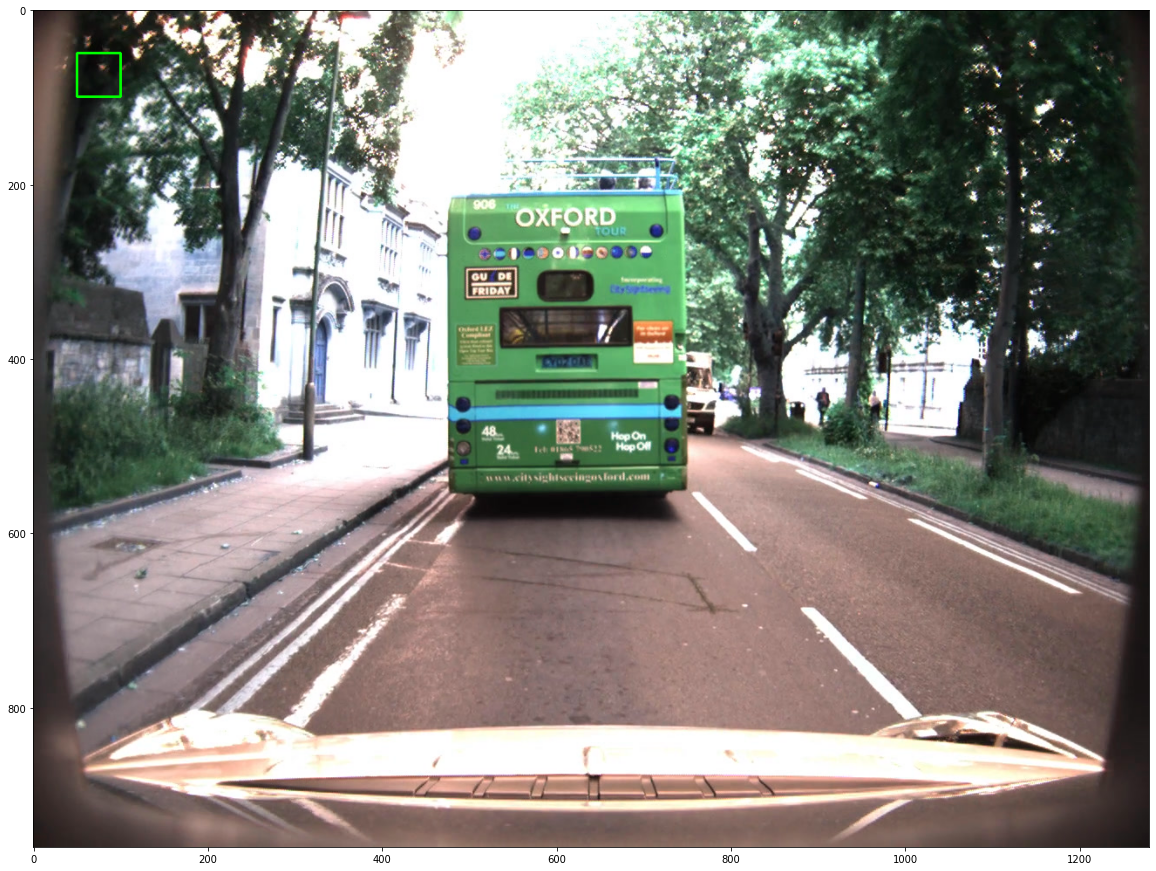

In [3]:

# show img with matplotlib
def show_img(img):
    plt.imshow(img)
    plt.show()

img = cv2.imread('/road/rgb-images/2014-06-26-09-53-12_stereo_centre_02/00237.jpg')
img= plot_box(img, (50, 50, 100, 100))
plt.rcParams['figure.figsize'] = (20, 20)


show_img